Defining universal constants:
- Magnetic field constant: $\mu_0 = 4 \pi \times 10^{-7}$
- Electric field constant: $\epsilon_0 = 8.854 \times 10^{-12}$
Config-specific constants:
- frequency = 25MHz
- Current = 1600A
- Power = 1kW
- $\omega = 2\pi f$
- wavenumber $k_0 = \frac{\omega}{c} = \omega \sqrt{\mu_0 \epsilon_0}$
- wavelength $\lambda_0 = \frac{2\pi}{k_0}$

I construct an interpolation of the density and temperature following a gaussian around the antenna and overlayed with the density/temperature radial profile as if it's parallel along the y direction

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

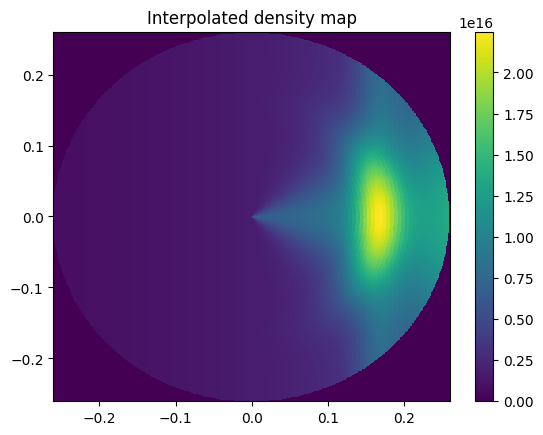

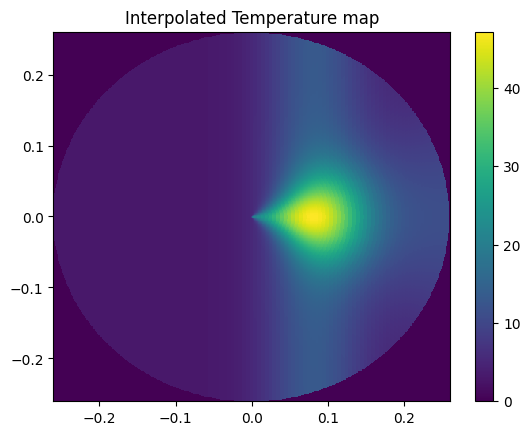

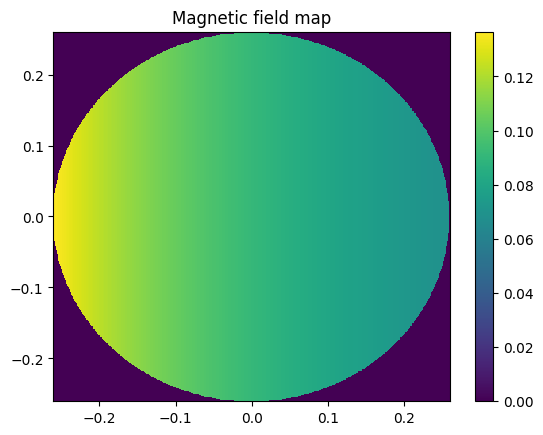

In [8]:
#%% Plasma Definition
#====================

# Machine definition
#-------------------
f = 25e6 #driving frequency
I = 1600 #A
P = 1000 #1kW IC
B0 = 5.7e-5*I #central magnetic field
R0 = 0.78 #machine center
a = 0.26 #minor radius

# Maxwell caracteristics
#-----------------------
mu0 = 4*np.pi*1e-7
eps0 = 8.854e-12

om=2*np.pi*f
k0=om*np.sqrt(mu0*eps0)
lambda0 = 2*np.pi/k0

# Plasma profile
#---------------

data = np.loadtxt("TOMAS_profile.txt", comments='%')
"""
def Density1D(data,r):
    x = 0.78 + 0.26 - data[:,0]
    nre = data[:,1]
    ne[ne<1e8] = 1e8 # to avoid too low, unphysical densities
    stepsize = 1e-3 #x stepsize
    xspan = np.arange(R0-a,R0+a,stepsize)
    nspan = np.interp(xspan, x, ne)
    return nspan
"""
def find_nearest(array, value):
    indices = np.abs(array - value).argmin(0)
    return indices
    
def Density2D(data,theta,rpos,x):
    ne = data[:,1]
    r = a - data[:,0] #0-50 -> -26-26
    sigma = np.pi/7
    Gaussian = (1/(sigma*np.sqrt(2*np.pi)))*np.exp((-1/2)*(abs(theta)/sigma)**2)
    index1 = find_nearest(r,rpos)
    index2 = find_nearest(r,x)
    return 3/4*Gaussian*(ne[index1]) + ne[index2]/4

def XYtoDensity(data,x,y):
    theta = np.arctan2(y,x) # -180 tot 180 graden
    rpos = np.sqrt(x**2+y**2)
    if rpos > a: return 0 #enkel in TOMAS
    if abs(x) != x: rpos = -rpos #aangezien we niet radieel ma diametrisch profiel hebben
    n_thetar = Density2D(data,theta,rpos,x)
    return n_thetar

def Temperature2D(data,theta,rpos,x):
    Te = data[:,2]
    r = a - data[:,0] #0-50 -> -26-26
    sigma = np.pi/7
    Gaussian = (1/(sigma*np.sqrt(2*np.pi)))*np.exp((-1/2)*(abs(theta)/sigma)**2)
    index1 = find_nearest(r,rpos)
    index2 = find_nearest(r,x)
    return 3/4*Gaussian*(Te[index1]) + Te[index2]/4

def XYtoTemperature(data,x,y):
    theta = np.arctan2(y,x) # -180 tot 180 graden
    rpos = np.sqrt(x**2+y**2)
    if rpos > a: return 0 #enkel in TOMAS
    if abs(x) != x: rpos = -rpos #aangezien we niet radieel ma diametrisch profiel hebben
    T_thetar = Temperature2D(data,theta,rpos,x)
    return T_thetar
def XYtoB(I,x,y):
    r = np.sqrt(x**2 + y**2)
    if r > a: return 0
    B = 5.7e-5*I*R0/(R0 + x)
    return B

stepsize = 1e-3 #x stepsize

resolution = 500
x = np.linspace(-a, a, resolution)
y = np.linspace(-a, a, resolution)
ne_ = np.array([XYtoDensity(data,i,j) for j in y for i in x])
Te_ = np.array([XYtoTemperature(data,i,j) for j in y for i in x])
B_ = np.array([XYtoB(I,i,j) for j in y for i in x])

X, Y = np.meshgrid(x, y)
ne = ne_.reshape(resolution, resolution)
Te = Te_.reshape(resolution, resolution)
B = B_.reshape(resolution, resolution)

plt.title("Interpolated density map")
plt.pcolor(X, Y, ne)
plt.colorbar()
plt.savefig("densitymap.pdf")
plt.show()

plt.title("Interpolated Temperature map")
plt.pcolor(X, Y, Te)
plt.colorbar()
plt.savefig("temperaturemap.pdf")
plt.show()

plt.title("Magnetic field map")
plt.pcolor(X, Y, B)
plt.colorbar()
plt.savefig("BMap.pdf")
plt.show()



# Mesh

Now we're going to create a mesh for the vessel + antenna in 2D, we do this by defining 3 circles: 1 for the vessel and two which we'll substract to get a torus-like shape. we then further substract from this torus to get an antenna shape.

In [3]:
from ngsolve import *
import netgen.geom2d as geom2d
from ngsolve.webgui import Draw
from netgen.geom2d import CSG2d, Circle, Rectangle

In [4]:
geo = CSG2d()
VesselWall = Circle( center=(0,0), radius=0.26, mat="Plasma", bc="wall" )
CircleWithAntennaRadius = Circle( center=(0,0), radius=0.215, mat="copper", bc="AntennaOuter" )
AntennaCut1 = Rectangle( pmin=(-3,-1), pmax=(0,1), mat="copper", bc="bc_cut" )
AntennaCut2 = Rectangle( pmin=(-4,0.21*np.sin(np.deg2rad(40))), pmax=(1-0.78,1 + 0.21*np.sin(np.deg2rad(40))), mat="copper", bc="bc_cut" )
AntennaCut3 = Rectangle( pmin=(-2,-1 + 0.21*np.sin(np.deg2rad(-40))), pmax=(1-0.78,0.21*np.sin(np.deg2rad(-40))), mat="copper", bc="bc_cut" )
AntennaConnect = Rectangle( pmin=(0.215,-0.005), pmax=(0.26,0.005), mat="copper", bc="bc_copper" )
CircleWithLessthanAntennaRadius = Circle( center=(0,0), radius=0.210, mat="copper", bc="AntennaInner" )

Antenna = CircleWithAntennaRadius - CircleWithLessthanAntennaRadius - AntennaCut1 - AntennaCut2 - AntennaCut3
System = Antenna + VesselWall

geo.Add(Antenna)
geo.Add(VesselWall)

In [5]:
mesh = Mesh(geo.GenerateMesh (maxh=0.16/4))
Draw(mesh)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

BaseWebGuiScene

# FEM computation

FEM or Finite Element Method is a way of computation which discretizes space and computes within those cells.
We choose a dirichlet boundary condition (have the fields equal a certain value) at the Antenna and the vessel wall.

HCurl creates ??? and H1 creates ???

Combining these we get the fem space 'fem' from which we can derive $E_t$ and $E_z$

In [6]:
order_mesh=4 # optimal 4 or 5
V = HCurl(mesh, order=order_mesh, complex=True, dirichlet='Antenna|wall') #nedelec in plane
Q = H1(mesh, order=order_mesh-1, complex=True, dirichlet='Antenna|wall') #Lagrange 2 perp
fem = V*Q #fem space composed of these 2 spaces

et, ez = fem.TrialFunction()
vt, vz = fem.TestFunction()

normal = specialcf.normal(mesh.dim) #Normal vector

# Creating a plasma

Let's now initialize a cold plasma, the arguments are:
- f: the driving frequency
- R: The 'space' of the plasma, which I guess should be a 3D array with coordinates?
- ne: The density of the plasma
- B the magnetic field of the plasma
- Te: the electron temperature
- Ti: the ion temperature (here equal to Te)
- s: the species present in the plasma

In [7]:
from pyVICI.pyPlasma import Plasma,PlasmaSpecies

#Species in the plasma
symbol=('e','H')
Z = (-1,1)
A = (0,1)
C = (1,1)
nuom = np.zeros((3))*1e-3
s = PlasmaSpecies(symbol, Z, A, C, nuom)

R = ?

#Cold plasma tensor
TOMAS_Plasma = Plasma(f,R,ne,B,Te,Te,s)

NameError: name 'R' is not defined

In [ ]:
# 2x2 FW matrix
epsRZ11 = VoxelCoefficient((R[0,0],Z[0,0]), (R[-1,-1],Z[-1,-1]),TOMAS_Plasma.epsilon[0,0].T, linear=True)
epsRZ12 = VoxelCoefficient((R[0,0],Z[0,0]), (R[-1,-1],Z[-1,-1]),TOMAS_Plasma.epsilon[0,1].T, linear=True)
epsRZ21 = VoxelCoefficient((R[0,0],Z[0,0]), (R[-1,-1],Z[-1,-1]),TOMAS_Plasma.epsilon[1,0].T, linear=True)
epsRZ22 = VoxelCoefficient((R[0,0],Z[0,0]), (R[-1,-1],Z[-1,-1]),TOMAS_Plasma.epsilon[1,1].T, linear=True)
epsRZ = CF(((epsRZ11,epsRZ12),(epsRZ21,epsRZ22)), dims=(2,2))

# 1x1 FW/SW share
epsRZ31 = VoxelCoefficient((R[0,0],Z[0,0]), (R[-1,-1],Z[-1,-1]),TOMAS_Plasma.epsilon[2,0].T, linear=True)
epsRZ32 = VoxelCoefficient((R[0,0],Z[0,0]), (R[-1,-1],Z[-1,-1]),TOMAS_Plasma.epsilon[2,1].T, linear=True)

eps_perp = VoxelCoefficient((R[0,0],Z[0,0]), (R[-1,-1],Z[-1,-1]),TOMAS_Plasma.epsilon[2,2].T, linear=True)
eps_perpRZ13 = VoxelCoefficient((R[0,0],Z[0,0]), (R[-1,-1],Z[-1,-1]),TOMAS_Plasma.epsilon[0,2].T, linear=True)
eps_perpRZ23 = VoxelCoefficient((R[0,0],Z[0,0]), (R[-1,-1],Z[-1,-1]),TOMAS_Plasma.epsilon[1,2].T, linear=True)

# esptot
eps_tot = CF(((epsRZ11,epsRZ12,eps_perpRZ13),(epsRZ21,epsRZ22,eps_perpRZ23),(epsRZ31,epsRZ32,eps_perp)), dims=(3,3))

showplot=1
if showplot:
    Draw(epsRZ11.imag,mesh,wireframe=False)
    Draw(epsRZ11.real,mesh,wireframe=False)
    Draw(eps_perp.real,mesh,wireframe=False)
    Draw(eps_perp.imag,mesh,wireframe=False)